In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Neuron ... n
# Input ... x
# Weight ... w ... hold by a synapse. The snyaptic strength for the input
# A synapse interacts with the input to the Neuron multiplicatively
# Flow ... F ... So what flows to the neuron is w * x
# There are multiple inputs
# Bias ... b ... trigger happiness
# Activiation Function ... f ... tanh or sigmoid. Also called squashing functions because it smoothly caps it out to -1 or +1.
# Out ... o ... What comes out of the neuron when the Activiation Function is applied to the sum of the Flows multiplied by the Bias.

In [3]:
from graphviz import Digraph

def trace(rootValue):
    nodes, edges = set(), set()
    def build(value):
        if value not in nodes:
            nodes.add(value)
            for term in value._terms:
                edges.add((term, value))
                build(term)
    build(rootValue)
    return nodes, edges

def draw_dot(rootValue, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(rootValue)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n._label, n.data, n.grad), shape='record')
        if n._op != 'prim':
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [12]:
class Value:
    """ 
        stores a single scalar value and its gradient
        Implementing backward propagation
    """
    def __init__(self, data: float, _terms=(), _op='prim', _label="?"):
        """ 
        data: a float or integer
        _terms: terms this value combines, starting with self
        _op: operation by how the terms are combined
        _label: label for self
        """
        self.data = data
        self.grad = 0 # by default 0, means initially no effect, does not effect the output. 
                      # So changing the variable does not effect the Loss function
        # internal variables used for micrograd graph construction
        #
        # the function that is doing the chain rule. How to store the output gradient 
        # into the input gradient. Propagtes the gradient
        self._backward = lambda: None; # lambda: None is the empty function, for leaf nodes.
        self._terms = set(_terms)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self._label = _label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            # self.grad = ???
            # the local derivative of an addition is always 1.0
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            self.grad = 1.0 * out.grad
            # other.grad = ???
            # the local derivative of an addition is always 1.0
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            # self.grad = ???
            # the local derivative of a multiplication is the data of the other multiplicant
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            self.grad = other.data * out.grad
            # other.grad = ???
            # the local derivative of a multiplication is the data of the other multiplicant
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    def tanh(self):
        x = self.data
        # See https://en.wikipedia.org/wiki/Hyperbolic_functions#Exponential_definitions
        # Hyperbolic tangent
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) 
        out = Value(t, (self,), 'tanh')
        def _backward():
            # self.grad = ???
            # the local derivative of a tanh is https://en.wikipedia.org/wiki/Hyperbolic_functions#Derivatives times the 
            # already? backpropagated out grad
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
        
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad}, op={self._op}, label={self._label})"

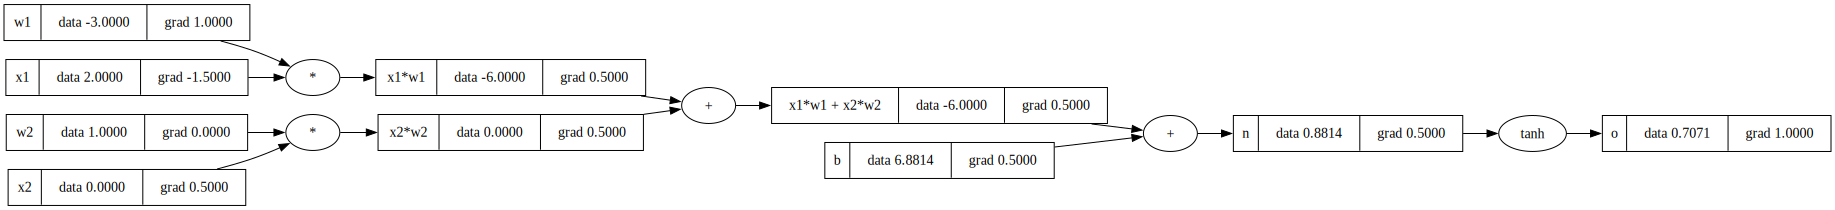

In [17]:
def lol1():
    # A 2 dimensional neuron with Input x1 and x2
    x1 = Value(2.0, _label='x1')
    x2 = Value(0.0, _label='x2')
    # The Weights
    w1 = Value(-3.0, _label='w1')
    w2 = Value(1.0, _label='w2')
    # The Bias
    b = Value(6.8813735870195432, _label='b')
    # The Flows
    x1w1 = x1 * w1; x1w1._label = 'x1*w1'
    x2w2 = x2 * w2; x2w2._label = 'x2*w2'
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1*w1 + x2*w2'
    # The Neuron
    n = x1w1x2w2 + b; n._label = 'n'
    # The Output
    o = n.tanh(); o._label = 'o'
    # Backwards setting gradients
    # 1. do/do
    #    do/do = 1.0
    o.grad = 1.0
    # 2. call _backward in reversed topological order
    o._backward()
    n._backward()
    x1w1x2w2._backward()
    x1w1._backward()
    x2w2._backward()
    x1._backward()
    w1._backward()
    x2._backward()
    w2._backward()
    return o
    
draw_dot(lol1())